In [2]:
import imageio
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import IPython.display
%matplotlib inline

In [3]:
from utils import get_data
version = '1.0'
data = get_data(version, '../data')
df = data['blockworld']

def parse_state(state):
    return tuple((tuple(filter(None, col.split(','))) 
                  for col in state.split(':')))

def dump_state(state):
    return ':'.join(','.join(col) for col in state)

assert parse_state('A,B:C:') == (('A', 'B'), ('C',), ())
assert dump_state(parse_state('A,B:C:')) == 'A,B:C:'

df.states = df.states.apply(lambda states: list(map(parse_state, states)))

Error importing rpy2


In [4]:
def _state_sequence_to_images(states):
    bsize = 100
    num_blocks = 5
    num_spaces = 3
    blue = tuple(int(c, 16) for c in ['22', '99', 'ee'])
    font = ImageFont.truetype("Arial", 60)

    images = []

    for state in states:
        im = Image.new('RGBA', (num_spaces * bsize, num_blocks * bsize), color='white')
        draw = ImageDraw.Draw(im)
        for colidx, col in enumerate(state):
            for rowidx, label in enumerate(col):
                xy = (colidx * bsize, (num_blocks - rowidx - 1) * bsize)
                lowerright = (xy[0] + bsize - 1, xy[1] + bsize - 1)
                draw.rectangle([xy, lowerright], fill=blue, outline='black')
                draw.text((xy[0] + 0.28 * bsize, xy[1] + 0.16 * bsize), label, font=font)
        del draw

        images.append(im)

    return images

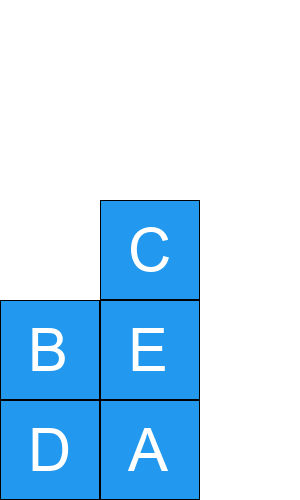

In [5]:
# Picking an arbitrary trial to show first frame...

states = df.iloc[5, :].states

images = _state_sequence_to_images(states)
IPython.display.display(images[0])
# HACK or plt.imshow(np.asarray(im))

In [44]:
# Converting this arbitrary trial to movie
imageio.mimsave('movie.mp4', [np.asarray(im) for im in images], fps=2)

In [45]:
%%HTML
<video width="320" height="240" controls>
  <source src="movie.mp4" type="video/mp4">
</video>

In [101]:
# Make all movies!

def _state_name(state):
    # HACK copied from below...
    # HACK
    # Removing : since file system doesn't like it.
    # graphviz might not either? since it warns about "port"
    return dump_state(state).replace(':', '_')

# HACK also repeated from below...
if not os.path.exists('output'):
    os.mkdir('output')

for _, row in tqdm(list(df.iterrows())):
    images = _state_sequence_to_images(row.states)
    fn = f'output/movie-pid{row.pid}-{_state_name(row.states[0])}.mp4'
    imageio.mimsave(fn, [np.asarray(im) for im in images], fps=2)

# Graph

In [6]:
import os, shutil
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from graphviz import Digraph

unique_problems = set([s[0] for s in df.states])
unique_problems_5block = [
    p for p in unique_problems
    if sum(len(col) for col in p) == 5
]
# We have 15 problems across all people
assert len(unique_problems_5block) == 15, 'Found {} 5-block problems.'.format(len(unique_problems_5block))

total states 2 total unique edges 1


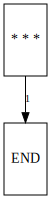

In [73]:
def _state_name(state):
    # Removing : since file system doesn't like it.
    # graphviz might not either? since it warns about "port"
    return dump_state(state).replace(':', '_')

def _make_problem_graph(df, initial):
    end_state = ((), tuple(sorted([l for col in initial for l in col], reverse=True)), ())

    if not os.path.exists('graph-tmp'):
        os.mkdir('graph-tmp')

    problem_df = df[df.states.apply(lambda s: s[0] == initial)]
    total_subjects = problem_df.shape[0]

    state_counter = Counter()
    states = set()
    for _, row in problem_df.iterrows():
        # Make unique list of state pairs for each subject.
        # - want them unique within a subject so we don't double count a subject if they made the same move twice.
        state_pairs = {
            (row.states[idx - 1], row.states[idx])
            for idx in range(1, len(row.states))
        }
        # Add these pairs to the counter.
        state_counter.update(state_pairs)
        # Add states to full list of states
        states |= set(row.states)

    print('total states', len(states), 'total unique edges', len(state_counter))

    # Make graph with each node, and add edge annotated appropriately for each state pair.
    d = Digraph(engine='dot')
    for state in states:
        # Generate and save images for each of the states visited for a problem.
        im = _state_sequence_to_images([state])[0]
        fn = f'graph-tmp/{_state_name(state)}.png'
        im.save(fn)

        d.node(
            _state_name(state),
            '* * *' if state == initial else
            'END' if state == end_state else '',
            image=fn,
            fixedsize='true',
            width='0.6pt',
            height='1pt',
            shape='box',
        )
    for (st1, st2), count in state_counter.items():
        # - will either do opacity or we'll label the edge with a number
        d.edge(_state_name(st1), _state_name(st2), label=str(count), fontsize="10pt")

    # Delete the directory with images. ?? or not
    #shutil.rmtree('graph-tmp')

    return d

initial = list(unique_problems_5block)[8]
_make_problem_graph(df, list(unique_problems)[0])

In [ ]:
if not os.path.exists('output'):
    os.mkdir('output')

for initial in unique_problems_5block:
    d = _make_problem_graph(initial)
    d.render(f'output/problem-graph-{_state_name(initial)}', format='png')

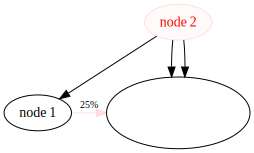

In [24]:
# HACK some notes on this stuff...

# Make unique list of state pairs for each subject.
# Generate and save each of the above images.
# - want them unique within a subject so we don't double count a subject if they made the same move twice.
# Group pairs and count.
# Make graph with each node, and add edge annotated appropriately for each state pair.
# - will either do opacity or we'll label the edge with a number

d = Digraph(comment='The Round Table')

d.graph_attr['truecolor'] = 'true'

d.node(
    'A', 'node 2',
    color='#ff0000' + '%x' % 30,
    fontcolor='#ff0000' + '%x' % 5,
    fillcolor='#ff0000' + '%x' % 5,
    labelfontcolor='#ff0000' + '%x' % 5,
    pencolor='#ff0000' + '%x' % 5,
    style='filled',
)
d.node('B', 'node 1')
# HACK it doesn't support opacity...
#d.node('L', '<<TABLE><TR><TD><IMG SRC="figure_eeg.png"/></TD></TR></TABLE>>')
#d.node('L', '<<TABLE><TR><TD><IMG WIDTH="100" HEIGHT="100" SRC="figure_eeg.png"/></TD></TR></TABLE>>')
d.node(
    'L', '',
    image='figure_eeg.png',
    fixedsize='true',
    width='2pt',
    height='1pt',
)

d.edges(['AB', 'AL'])
d.edges(['AL']) # look 2 edges
d.edge('B', 'L', constraint='false', color='#ff0000' + '%x' % 30, label='25%', fontsize="10pt")

#graph [truecolor bgcolor="#ff00005f"]
#node [style=filled fillcolor="#00ff005f"]

#>>> ps.graph_attr['rankdir'] = 'LR'
#>>> ps.edge_attr.update(arrowhead='vee', arrowsize='2')

d